This is a notebook developed by Dustin Lang and Phil Marshall in Spring 2015, and distributed by them under the GPLv2 licence. We can pull bits out of this and make good use of them in some expanded notebooks, before removing this original.

In [1]:
from straightline_utils import *
%matplotlib inline
from matplotlib import rcParams
rcParams['savefig.dpi'] = 100

#Fitting a straight line

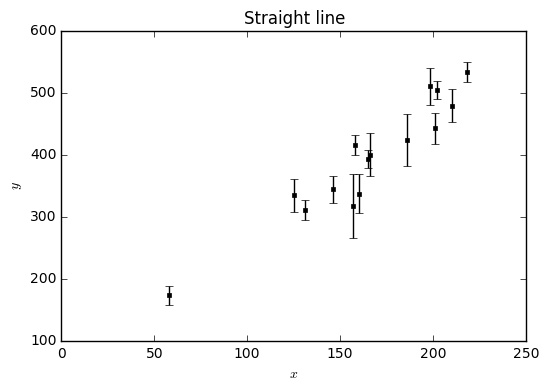

In [2]:
(x,y,sigmay) = get_data_no_outliers()
plot_yerr(x, y, sigmay)

## Least squares fitting

An industry standard: find the slope and intercept that minimize the mean square residual. Since the data depend linearly on the parameters, the least squares solution can be found by a matrix inversion and multiplication, conveneniently packed in `numpy.linalg`.

Least Squares (maximum likelihood) estimator: 34.8459413134 2.23253621695


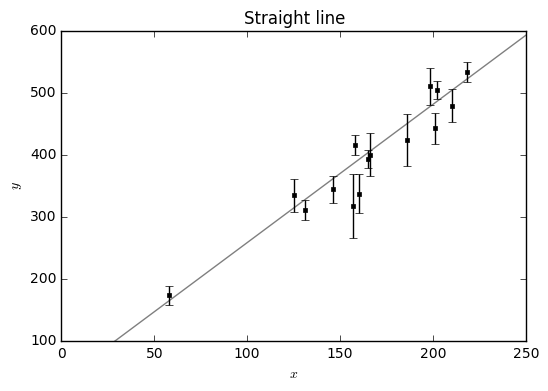

In [3]:
# Linear algebra: weighted least squares
N = len(x)
A = np.zeros((N,2))
A[:,0] = 1. / sigmay
A[:,1] =  x / sigmay
b = y / sigmay
theta,nil,nil,nil = np.linalg.lstsq(A, b)
plot_yerr(x, y, sigmay)
b_ls,m_ls = theta
print 'Least Squares (maximum likelihood) estimator:', b_ls,m_ls
plot_line(m_ls, b_ls);

## Evaluating posterior probability on a grid

This procedure will get us the Bayesian solution to the problem - not an estimator, but a probability distribution for the parameters m and b. This PDF captures the uncertainty in the model parameters given the data. For simple, 2-dimensional parameter spaces like this one, evaluating on a grid is not a bad way to go. We'll see that the least squares solution lies at the peak of the posterior PDF - for a certain set of assumptions about the data and the model.

In [4]:
def straight_line_log_likelihood(x, y, sigmay, m, b):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are
    *y_t = m * x + b*

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept

    Returns: scalar log likelihood
    '''
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * sigmay))) +
            np.sum(-0.5 * (y - (m*x + b))**2 / sigmay**2))
    
def straight_line_log_prior(m, b):
    return 0.
    
def straight_line_log_posterior(x,y,sigmay, m,b):
    return (straight_line_log_likelihood(x,y,sigmay, m,b) +
            straight_line_log_prior(m, b))


Grid maximum posterior values: 27.0 2.28888888889


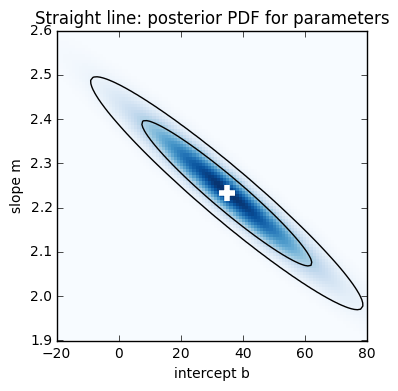

In [5]:
# Evaluate log P(m,b | x,y,sigmay) on a grid.
# Set up grid
mgrid = np.linspace(mlo, mhi, 100)
bgrid = np.linspace(blo, bhi, 101)
log_posterior = np.zeros((len(mgrid),len(bgrid)))
# Evaluate log probability on grid
for im,m in enumerate(mgrid):
    for ib,b in enumerate(bgrid):
        log_posterior[im,ib] = straight_line_log_posterior(x, y, sigmay, m, b)
# Convert to probability density and plot
posterior = np.exp(log_posterior - log_posterior.max())
plt.imshow(posterior, extent=[blo,bhi, mlo,mhi],cmap='Blues',
           interpolation='nearest', origin='lower', aspect=(bhi-blo)/(mhi-mlo),
           vmin=0, vmax=1)
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')

i = np.argmax(posterior)
i,j = np.unravel_index(i, posterior.shape)
print 'Grid maximum posterior values:', bgrid[i], mgrid[j]

plt.title('Straight line: posterior PDF for parameters');
plt.plot(b_ls, m_ls, 'w+', ms=12, mew=4);
plot_mb_setup();

## MCMC Sampling

In problems with higher dimensional parameter spaces, we need a more efficient way of approximating the posterior PDF - both when characterizing it in the first place, and then when doing integrals over that PDF (to get the marginalized PDFs for the parameters, or to compress them in to single numbers with uncertainties that can be easily reported). In most applications it's sufficient to approximate a PDF with a (relatively) small number of samples drawn from it; MCMC is a procedure for drawing samples from PDFs.  

In [6]:
def straight_line_posterior(x, y, sigmay, m, b):
    return np.exp(straight_line_log_posterior(x, y, sigmay, m, b))

In [7]:
# initial m, b
m,b = 2, 0

# step sizes
mstep, bstep = 0.1, 10.
        
# how many steps?
nsteps = 10000
    
chain = []
probs = []
naccept = 0
    
print 'Running MH for', nsteps, 'steps'

# First point:
L_old    = straight_line_log_likelihood(x, y, sigmay, m, b)
p_old    = straight_line_log_prior(m, b)
prob_old = np.exp(L_old + p_old)

for i in range(nsteps):
    # step
    mnew = m + np.random.normal() * mstep
    bnew = b + np.random.normal() * bstep

    # evaluate probabilities
    # prob_new = straight_line_posterior(x, y, sigmay, mnew, bnew)

    L_new    = straight_line_log_likelihood(x, y, sigmay, mnew, bnew)
    p_new    = straight_line_log_prior(mnew, bnew)
    prob_new = np.exp(L_new + p_new)

    if (prob_new / prob_old > np.random.uniform()):
        # accept
        m = mnew
        b = bnew
        L_old = L_new
        p_old = p_new
        prob_old = prob_new
        naccept += 1
    else:
        # Stay where we are; m,b stay the same, and we append them
        # to the chain below.
        pass

    chain.append((b,m))
    probs.append((L_old,p_old))
print 'Acceptance fraction:', naccept/float(nsteps)

Running MH for 10000 steps
Acceptance fraction: 0.3015


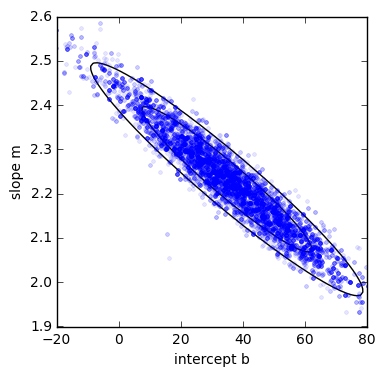

In [8]:
# Pull m and b arrays out of the Markov chain and plot them:
mm = [m for b,m in chain]
bb = [b for b,m in chain]
# Scatterplot of m,b posterior samples
plt.clf()
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')
plt.gca().set_aspect((bhi-blo)/(mhi-mlo))
plt.plot(bb, mm, 'b.', alpha=0.1)
plot_mb_setup()
plt.show()

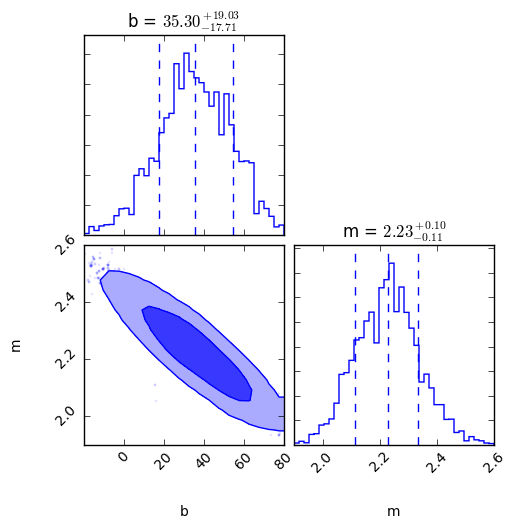

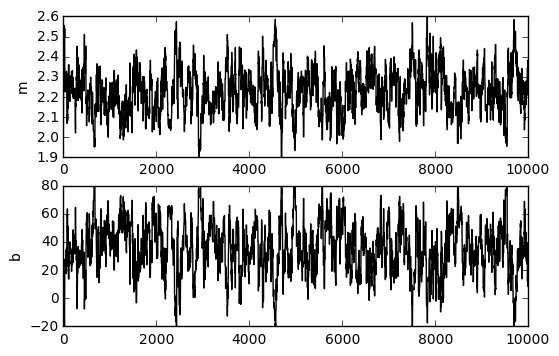

In [9]:
# 1 and 2D marginalised distributions:
import triangle
triangle.corner(chain, labels=['b','m'], range=[(blo,bhi),(mlo,mhi)],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, smooth=1.0);
plt.show()

# Traces, for convergence inspection:
plt.clf()
plt.subplot(2,1,1)
plt.plot(mm, 'k-')
plt.ylim(mlo,mhi)
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'k-')
plt.ylabel('b')
plt.ylim(blo,bhi)
plt.show()

## Model checking

How do we know if our model is any good? There are two properties that "good" models have: the first is accuracy, and the second is efficiency. Accurate models generate data that is *like* the observed data. What does this mean? First we have to define what similarity is, in this context. Visual impression is one very important way. Test statistics that capture relevant features of the data are another. Let's look at the posterior predictive distributions for the datapoints, and for a particularly interesting test statistic, the reduced chi-squared.

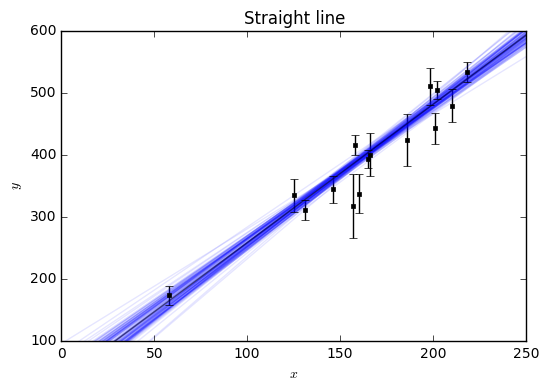

In [10]:
# Posterior predictive check, in data space
X = np.array(xlimits)
for i in (np.random.rand(100)*len(chain)).astype(int):
    b,m = chain[i]
    plt.plot(X, b+X*m, 'b-', alpha=0.1)
plot_line(m_ls, b_ls);
plot_yerr(x, y, sigmay)

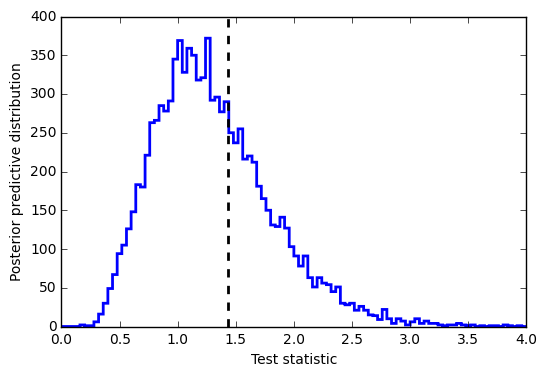

In [11]:
def test_statistic(x,y,sigmay,b_ls,m_ls):
   return np.sum((y - m_ls*x - b_ls)**2.0/sigmay**2.0)/(len(y)-2)

def mean_test_stat(x,y,sigmay):
    pass
    
T = np.zeros(len(chain))
for k,(b,m) in enumerate(chain):
    yp = b + m*x + np.random.randn(len(x)) * sigmay
    T[k] = test_statistic(x,yp,sigmay,b_ls,m_ls)
Td = test_statistic(x,y, sigmay, b_ls, m_ls)

plt.hist(T, 100, histtype='step', color='b', lw=2, range=(0,4))
plt.axvline(Td, color='k', linestyle='--', lw=2)
plt.xlabel('Test statistic')
plt.ylabel('Posterior predictive distribution');

Note that we did not have to look up the "chi squared distribution" - we can simply compute the posterior predictive distribution given our generative model.

## Intrinsic scatter

Now let's add an extra parameter to the model: intrinisc scatter. What does this mean? We imagine the model y values to be drawn from a PDF that is conditional on m, b and also s, the intrinsic scatter of the population. This scatter parameter can be inferred from the data as well: in this simple case we can introduce it, along with a "true" y value for each data point, and analytically marginalize over the "true" y's. This yields a new likelihood function, which looks as though it has an additional source of uncertainty in the y values - which is what scatter is.

In [12]:
def straight_line_with_scatter_log_likelihood(x, y, sigmay, m, b, log_s):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values have
    been drawn from N(mean=m * x + b, variance=(s^2)).

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept
    s: intrinsic scatter, Gaussian std.dev

    Returns: scalar log likelihood
    '''
    s = np.exp(log_s)
    V = sigmay**2 + s**2
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi*V)))) +
            np.sum(-0.5 * (y - (m*x + b))**2 / V))
    
def straight_line_with_scatter_log_prior(m, b, log_s):
    if log_s < np.log(slo) or log_s > np.log(shi):
        return -np.inf
    return 0.
    
def straight_line_with_scatter_log_posterior(x,y,sigmay, m,b,log_s):
    return (straight_line_with_scatter_log_likelihood(x,y,sigmay,m,b,log_s) +
            straight_line_with_scatter_log_prior(m,b,log_s))

def straight_line_with_scatter_posterior(x,y,sigmay,m,b,log_s):
    return np.exp(straight_line_with_scatter_log_posterior(x,y,sigmay,m,b,log_s))

In [13]:
# initial m, b, s
m,b,log_s = 2, 20, 0.

# step sizes
mstep, bstep, log_sstep = 1., 10., 1.

# how many steps?
nsteps = 30000
    
schain = []
sprobs = []
naccept = 0
    
print 'Running MH for', nsteps, 'steps'
L_old    = straight_line_with_scatter_log_likelihood(x, y, sigmay, m, b, log_s)
p_old    = straight_line_with_scatter_log_prior(m, b, log_s)
prob_old = np.exp(L_old + p_old)

for i in range(nsteps):
    # step
    mnew = m + np.random.normal() * mstep
    bnew = b + np.random.normal() * bstep
    log_snew = log_s + np.random.normal() * log_sstep

    # evaluate probabilities
    # prob_new = straight_line_with_scatter_posterior(x, y, sigmay, mnew, bnew, log_snew)

    L_new    = straight_line_with_scatter_log_likelihood(x, y, sigmay, mnew, bnew, log_snew)
    p_new    = straight_line_with_scatter_log_prior(mnew, bnew, log_snew)
    prob_new = np.exp(L_new + p_new)

    
    if (prob_new / prob_old > np.random.uniform()):
        # accept
        m = mnew
        b = bnew
        log_s = log_snew
        L_old = L_new
        p_old = p_new
        prob_old = prob_new
        naccept += 1
    else:
        # Stay where we are; m,b stay the same, and we append them
        # to the chain below.
        pass
        

    schain.append((b,m,np.exp(log_s)))
    sprobs.append((L_old,p_old))

print 'Acceptance fraction:', naccept/float(nsteps)

Running MH for 30000 steps
Acceptance fraction: 0.0342


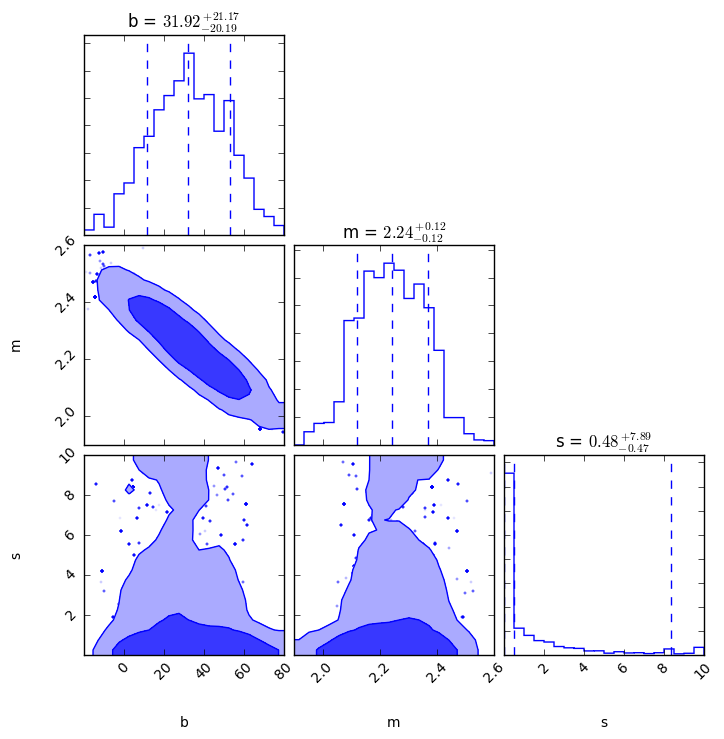

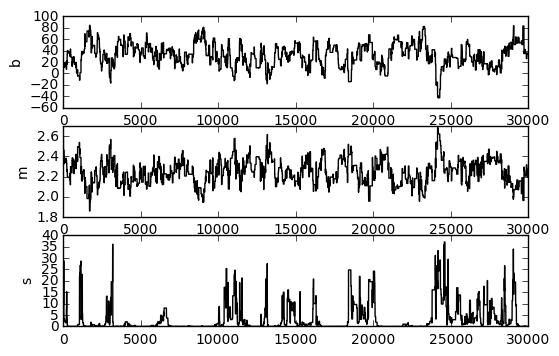

In [14]:
# Histograms:
import triangle
slo,shi = [0,10]
triangle.corner(schain, labels=['b','m','s'], range=[(blo,bhi),(mlo,mhi),(slo,shi)],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=20, smooth=1.0);
plt.show()

# Traces:
plt.clf()
plt.subplot(3,1,1)
plt.plot([b for b,m,s in schain], 'k-')
plt.ylabel('b')
plt.subplot(3,1,2)
plt.plot([m for b,m,s in schain], 'k-')
plt.ylabel('m')
plt.subplot(3,1,3)
plt.plot([s for b,m,s in schain], 'k-')
plt.ylabel('s')
plt.show()

## Evidence comparison for intrinsic scatter

The other virtue we are looking for in a model is *efficiency*. Not because this is intrinsically a good thing, but rather because the data might prefer it. We can compare two models, given the data, with their relative posterior probabilities. This is not easy, because we have to specify their prior probabilities, and then compute the probability of getting the data given each model (the "Evidence") - but under certain assumptions we can do this. 

Evidence computation is famously difficult - the simplest way is by simple Monte Carlo. We draw *prior* samples, and weight each one by the likelihood function. It's inefficient, but sometimes that doesn't matter.

In [15]:
# Draw a buttload of prior samples and hope for the best
N=50000
mm = np.random.uniform(mlo,mhi, size=N)
bb = np.random.uniform(blo,bhi, size=N)
slo,shi = [0.001,10]
log_slo = np.log(slo)
log_shi = np.log(shi)
log_ss = np.random.uniform(log_slo, log_shi, size=N)

log_likelihood_vanilla = np.zeros(N)
log_likelihood_scatter = np.zeros(N)

for i in range(N):
    log_likelihood_vanilla[i] = straight_line_log_likelihood(x, y, sigmay, mm[i], bb[i])
    log_likelihood_scatter[i] = straight_line_with_scatter_log_likelihood(x, y, sigmay, mm[i], bb[i], log_ss[i])

def logsum(x):
    mx = x.max()
    return np.log(np.sum(np.exp(x - mx))) + mx

log_evidence_vanilla = logsum(log_likelihood_vanilla) - np.log(N)
log_evidence_scatter = logsum(log_likelihood_scatter) - np.log(N)

print 'Log evidence vanilla:', log_evidence_vanilla
print 'Log evidence scatter:', log_evidence_scatter

print 'Odds ratio in favour of the vanilla model:', np.exp(log_evidence_vanilla - log_evidence_scatter)


Log evidence vanilla: -73.26906548
Log evidence scatter: -73.2361077927
Odds ratio in favour of the vanilla model: 0.967579499578


In this case there is very little to choose between the two models. Both provide comparably good fits to the data, so the only thing working against the scatter model is its extra parameter. However, the prior for `s` is very well -matched to the data (uniform in `log s` corresponds to a `1/s` distribution, favoring small values, and so there is not a very big "Occam's Razor" factor in the evidence. Both models are appropriate for this dataset.

Incidentally, let's look at a possible approximation for the evidence - the *posterior* mean log likelihood from our MCMC chains:

In [16]:
mean_log_L_vanilla = np.average(np.atleast_1d(probs).T[0])
mean_log_L_scatter = np.average(np.atleast_1d(sprobs).T[0])

print "No scatter:  Evidence, mean log L, difference: ",log_evidence_vanilla,mean_log_L_vanilla,(mean_log_L_vanilla - log_evidence_vanilla)
print "   Scatter:  Evidence, mean log L, difference: ",log_evidence_scatter,mean_log_L_scatter,(mean_log_L_scatter - log_evidence_scatter)

No scatter:  Evidence, mean log L, difference:  -73.26906548 -71.332197335 1.93686814503
   Scatter:  Evidence, mean log L, difference:  -73.2361077927 -71.3372145226 1.89889327009


The difference between the posterior mean log likelihood and the Evidence is the *Shannon information gained* when we updated the prior into the posterior. In both cases we gained about 2 bits of information - perhaps corresponding to approximately 2 good measurements (regardless of the number of parameters being inferred)?

In [60]:
def likelihood_outliers((m, b, pbad), (x, y, sigmay, sigmabad)):
    return np.prod(pbad * 1./(np.sqrt(2.*np.pi)*sigmabad) *
                        np.exp(-y**2 / (2.*sigmabad**2))
                        + (1.-pbad) * (1./(np.sqrt(2.*np.pi)*sigmay)
                                       * np.exp(-(y-(m*x+b))**2/(2.*sigmay**2))))

In [61]:
def prior_outliers((m, b, pbad)):
    if pbad < 0:
        return 0
    if pbad > 1:
        return 0
    return 1.

In [62]:
def prob_outliers((m,b,pbad), x,y,sigmay,sigmabad):
    return (likelihood_outliers((m,b,pbad), (x,y,sigmay,sigmabad)) *
            prior_outliers((m,b,pbad)))

Running MH for 100000 steps
(0.0%) (34.7%) (33.9%) (33.1%) (32.8%) (33.6%) (33.9%) (33.9%) (34.0%) (34.2%) (34.3%) (34.4%) (34.1%) (34.0%) (34.2%) (34.3%) (34.3%) (34.2%) (34.2%) (34.3%) (34.3%) (34.3%) (34.2%) (34.3%) (34.3%) (34.4%) (34.5%) (34.4%) (34.3%) (34.3%) (34.2%) (34.2%) (34.1%) (34.1%) (34.1%) (34.0%) (34.0%) (34.0%) (34.0%) (34.0%) (34.0%) (34.0%) (34.0%) (33.9%) (34.0%) (34.0%) (34.0%) (34.1%) (34.0%) (34.0%) (34.1%) (34.0%) (34.1%) (34.1%) (34.0%) (34.0%) (34.0%) (34.1%) (34.0%) (34.1%) (34.0%) (34.0%) (34.0%) (34.0%) (34.0%) (34.0%) (34.0%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (34.0%) (34.0%) (34.0%) (34.0%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%) (33.8%) (33.8%) (33.9%) (33.9%) (33.9%) (33.9%) (33.9%)

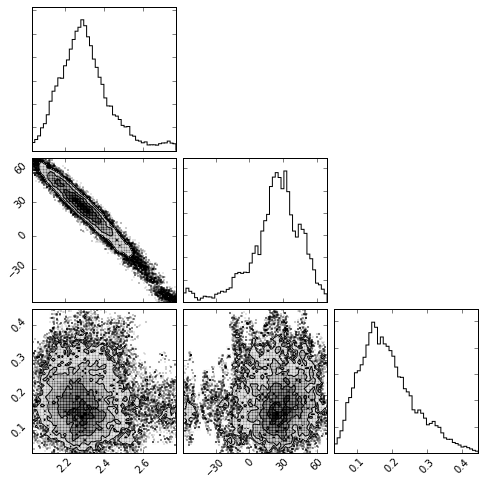

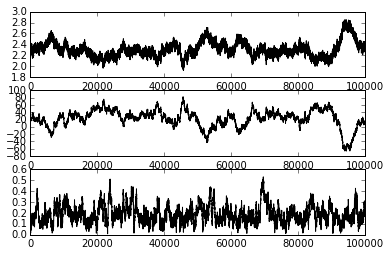

In [65]:
x,y,sigmay = data1.T
sigmabad = np.std(y)
prob_args = (x,y,sigmay,sigmabad)
mstep = 0.1
bstep = 1.
pbadstep = 0.01
proposal_args = ((mstep, bstep,pbadstep),)
m,b,pbad = 2.2, 30, 0.1
mh(prob_outliers, prob_args, gaussian_proposal, proposal_args,
    (m,b,pbad), 100000);

In [ ]:
def likelihood_t((m, b, nu), (x, y, sigmay)):
    return np.prod(pbad * 1./(np.sqrt(2.*np.pi)*sigmabad) *
                        np.exp(-y**2 / (2.*sigmabad**2))
                        + (1.-pbad) * (1./(np.sqrt(2.*np.pi)*sigmay)
                                       * np.exp(-(y-(m*x+b))**2/(2.*sigmay**2))))

In [97]:
def complexity_brewer_likelihood((m, b, q), (x, y, sigmay)):
    # q: quadratic term
    if q < 0:
        q = 0
    else:
        k = 0.01
        q = -k * np.log(1 - q)
    return np.prod(np.exp(-(y-(b+m*x+q*(x - 150)**2))**2/(2.*sigmay**2)))

In [98]:
def complexity_brewer_prior((m,b,q)):
    if q < -1:
        return 0.
    return 1.

In [99]:
def complexity_brewer_prob(params, *args):
    return complexity_brewer_prior(params) * complexity_brewer_likelihood(params, args)

x 58 218
y 173 533


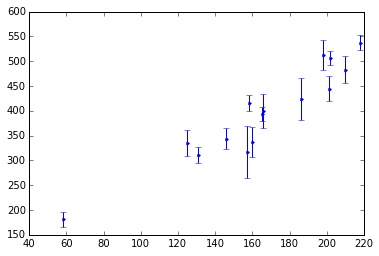

Running MH for 10000 steps
(0.0%) (30.8%) (30.5%) (31.8%) (32.0%) (32.0%) (31.7%) (31.9%) (31.9%) (31.8%)

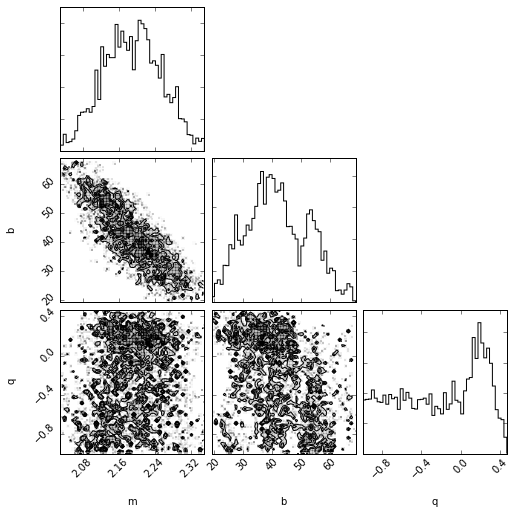

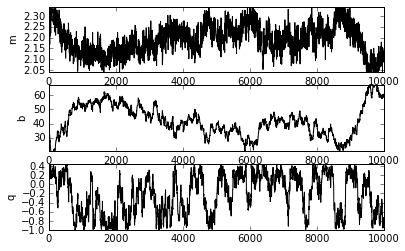

In [109]:
x,y,sigmay = get_data_no_outliers()
print 'x', x.min(), x.max()
print 'y', y.min(), y.max()
y = y + (0.001 * (x-150)**2)
prob_args = (x,y,sigmay)
mstep = 0.1
bstep = 1.
qstep = 0.1
proposal_args = ((mstep, bstep, qstep, cstep),)
m,b,q = 2.2, 30, 0.
plt.errorbar(x, y, fmt='.', yerr=sigmay)
plt.show()
mh(complexity_brewer_prob, prob_args, gaussian_proposal, proposal_args,
    (m,b,q), 10000, pnames=['m','b','q']);